# Embeddings vector search

This tutorial demonstrates the experimental API in the Python `cellxgene_census` package to search Census embeddings using [TileDB-Vector-Search](https://github.com/TileDB-Inc/TileDB-Vector-Search) indexes. We will generate [scVI embeddings](https://docs.scvi-tools.org/en/1.0.0/tutorials/notebooks/api_overview.html) for some test cells, search the Census scVI embeddings for nearest neighbors, and use them to predict cell type and tissue of the test cells.

To reproduce this notebook, `pip install 'cellxgene_census[experimental]' scvi-tools` and obtain the [pbmc3k blood cells data](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) and scVI model:

In [1]:
!mkdir -p data
!wget --no-check-certificate -q -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/pbmc3k_filtered_gene_bc_matrices.tar.gz -C data/

!mkdir -p scvi-human-2024-02-12
!wget --no-check-certificate -q -O scvi-human-2024-02-12/model.pt https://cellxgene-contrib-public.s3.us-west-2.amazonaws.com/models/scvi/2024-02-12/homo_sapiens/model.pt

**Contents**

1. Loading and embedding pbmc3k cells.
2. Search for similar Census cells.
3. Predicting cell metadata.

⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).

## Loading and embedding pbmc3k cells

In [2]:
import warnings

warnings.filterwarnings("ignore")

import cellxgene_census
import cellxgene_census.experimental
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import scvi

Load the pmbc3k cell data into an AnnData:

In [3]:
adata = sc.read_10x_mtx("data/filtered_gene_bc_matrices/hg19/", var_names="gene_ids")
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))
adata.obs["batch"] = "unassigned"

Run them through the scVI forward pass and extract their latent representation (embedding):

In [4]:
scvi.model.SCVI.prepare_query_anndata(adata, "scvi-human-2024-02-12")
vae_q = scvi.model.SCVI.load_query_data(
    adata,
    "scvi-human-2024-02-12",
)

# This allows for a simple forward pass
vae_q.is_trained = True
latent = vae_q.get_latent_representation()
adata.obsm["scvi"] = latent

INFO     File scvi-human-2024-02-12/model.pt already downloaded                                                    
INFO     Found 62.2% reference vars in query data.                                                                 
INFO     File scvi-human-2024-02-12/model.pt already downloaded                                                    


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


The scVI embedding vectors for each cell are now stored in the `scvi` obsm layer. Lastly, clean up the AnnData a little:

In [5]:
# filter out missing features
adata = adata[:, adata.var["gene_symbols"].notnull().values].copy()
adata.var.set_index("gene_symbols", inplace=True)
# assign placeholder cell_type and tissue_general labels
adata.var_names = adata.var["ensembl_id"]
adata.obs["cell_type"] = "Query - PBMC 10X"
adata.obs["tissue_general"] = "Query - PBMC 10X"

And for visualization, compute leiden clusters on the scVI embeddings. These will come at handy later on.

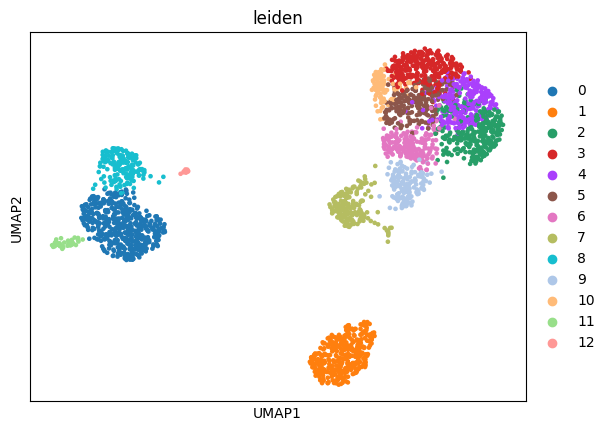

In [6]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color="leiden")

## Search for similar Census cells

Use the CELLxGENE Census experimental API to search the vector index of scVI embeddings.

In [7]:
%%time
CENSUS_VERSION = "2023-12-15"
neighbors = cellxgene_census.experimental.find_nearest_obs(
    "scvi", "homo_sapiens", CENSUS_VERSION,
    query=adata, 
    k = 30, 
    memory_GiB = 8,
    nprobe = 20
)

CPU times: user 58.5 s, sys: 51.6 s, total: 1min 50s
Wall time: 31.1 s


This accessed the cell embeddings in the `scvi` obsm layer and searched the latent space for the *k* nearest neighbors (by Euclidean distance) among the Census cell embeddings, returning the distances and obs `soma_joinid`s (*k* for each query cell).

In [8]:
neighbors

NeighborObs(distances=array([[0.20243207, 0.24619222, 0.24626343, ..., 0.35771364, 0.35771364,
        0.3578529 ],
       [0.39633602, 0.44447878, 0.44447878, ..., 0.6018935 , 0.6035782 ,
        0.6044336 ],
       [0.2957943 , 0.30667636, 0.30825144, ..., 0.5521871 , 0.55521137,
        0.55521137],
       ...,
       [0.13282368, 0.16312651, 0.17102817, ..., 0.34356815, 0.34431863,
        0.34656486],
       [0.19027619, 0.21736583, 0.22700316, ..., 0.35072052, 0.3570805 ,
        0.35889837],
       [0.30894524, 0.30962527, 0.33180258, ..., 0.43980873, 0.4401079 ,
        0.4412804 ]], dtype=float32), neighbor_ids=array([[44401673, 43906736, 43372133, ..., 51544031, 51427234, 51203542],
       [49811746, 33854211, 34746507, ..., 54523264, 50217492, 54367325],
       [45204189, 21218542, 48424603, ..., 48028212, 53333940, 45891611],
       ...,
       [45215753, 15715003, 45274933, ..., 45250148, 50295473, 54128750],
       [45149373, 48391702, 49371377, ..., 45093626, 50244751, 5

To explore these results, fetch an AnnData with each query cell's (single) nearest neighbor in scVI's latent space, including their embedding vectors:

In [9]:
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    neighbors_adata = cellxgene_census.get_anndata(
        census, "homo_sapiens", "RNA",
        obs_coords=sorted(neighbors.neighbor_ids[:,0].tolist()),
        obs_embeddings = ["scvi"],
        X_name = "normalized",
        column_names = {"obs": ["soma_joinid", "tissue", "tissue_general", "cell_type"]},
    )
neighbors_adata.var_names = neighbors_adata.var["feature_id"]

Make a UMAP visualization of these nearest neighbors:

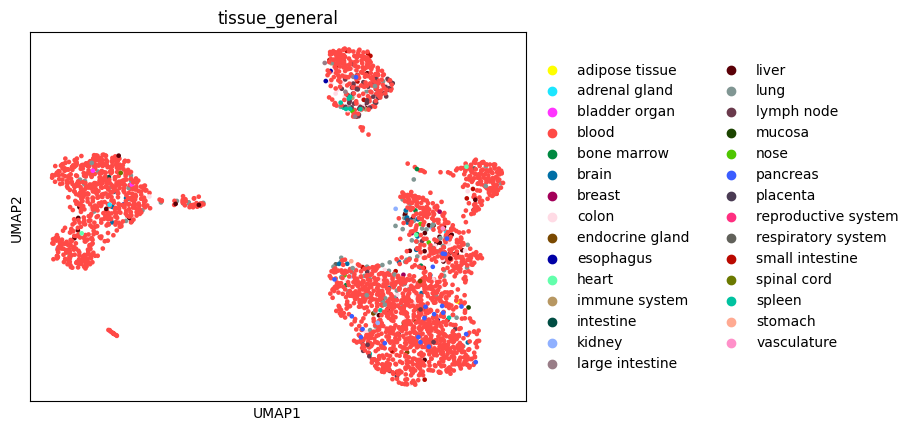

In [10]:
sc.pp.neighbors(neighbors_adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(neighbors_adata)
sc.pl.umap(neighbors_adata, color="tissue_general")

As expected, the nearest neighbors are largely Census blood cells, with some distinct cell type clusters.

Now display the pbmc3k query cells together with their Census nearest neighbors:

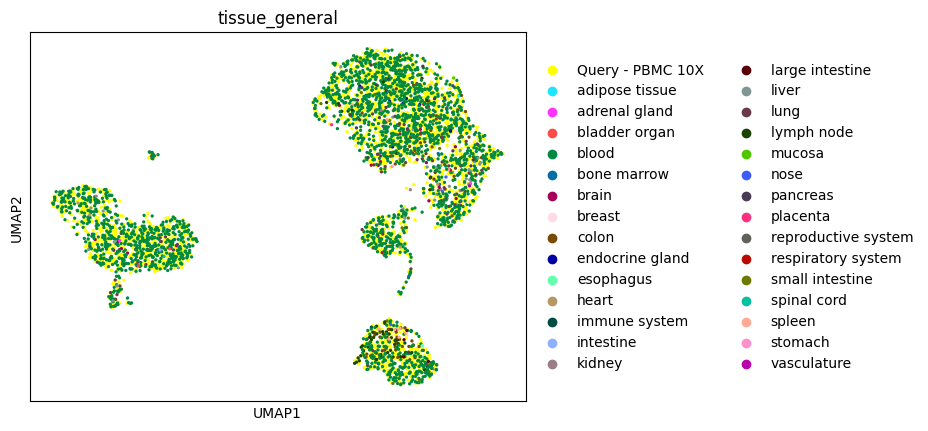

In [11]:
adata_concat = anndata.concat([adata, neighbors_adata])
sc.pp.neighbors(adata_concat, n_neighbors=15, use_rep="scvi")
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=["tissue_general"])

The neighbor clusters appear to correspond to cell type heterogeneity also present in the query.

## Predicting cell metadata

The experimental API also has a method to predict metadata attributes of the query cells, like `tissue_general` and `cell_type`, based on the Census nearest neighbors.

In [12]:
predictions = cellxgene_census.experimental.predict_obs_metadata(
    "homo_sapiens", CENSUS_VERSION, neighbors, ["tissue_general", "cell_type"]
)
predictions

,tissue_general,tissue_general_confidence,cell_type,cell_type_confidence
0,blood,0.900000,"effector memory CD8-positive, alpha-beta T cell",0.266667
1,blood,0.566667,B cell,0.733333
2,blood,0.633333,CD4-positive helper T cell,0.266667
3,blood,0.766667,classical monocyte,0.633333
4,blood,1.000000,natural killer cell,0.600000
...,...,...,...,...
2695,blood,0.600000,macrophage,0.300000
2696,blood,0.766667,plasmablast,0.500000
2697,blood,0.966667,B cell,0.566667
2698,blood,1.000000,naive B cell,0.600000


Unlike the above visualizations of *single* nearest neighbors, these predictions are informed by each query cell's *k*=30 neighbors, with an attached confidence score.

These predictions can be added to the original AnnData object for visualization.

In [13]:
predictions.index = adata.obs.index
predictions = predictions.rename(columns = {"cell_type": "predicted_cell_type"})
adata.obs = pd.concat([adata.obs, predictions], axis=1)

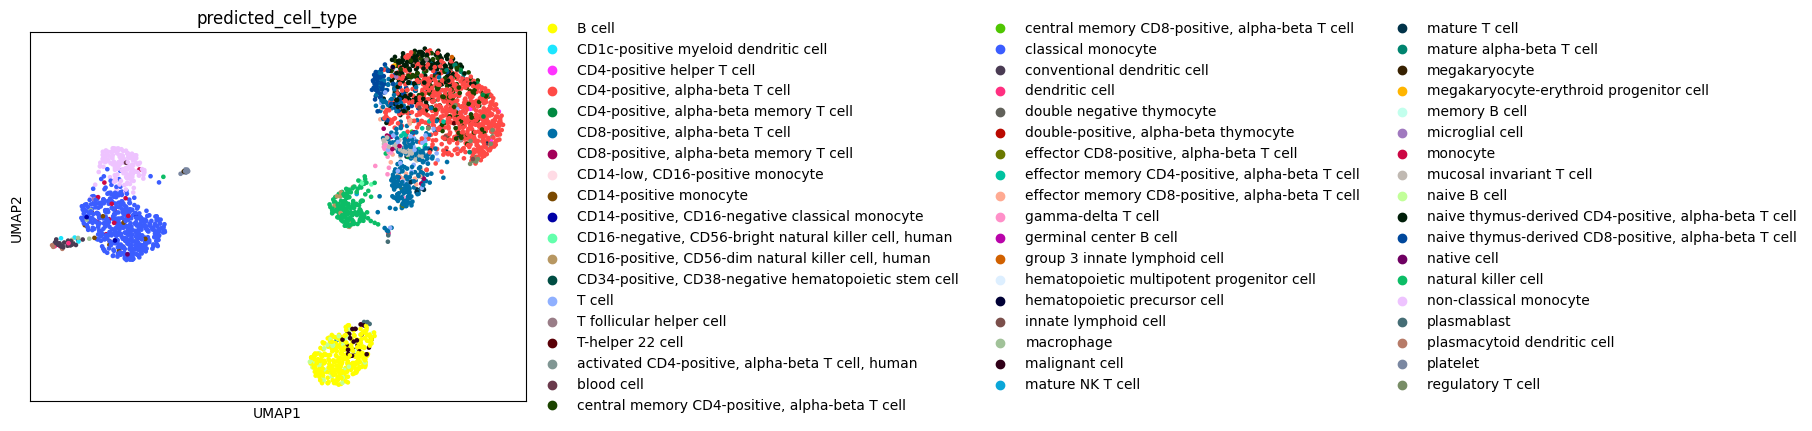

In [14]:
sc.pl.umap(adata, color="predicted_cell_type")

Now the leiden clusters calculated at the beginning can be annotated by popular vote, whereby each cluster gets assigned the most common predicted cell type from the previous step.

In [15]:
adata.obs["predicted_consolidated_cell_type"] = ""
for leiden_cluster in adata.obs["leiden"].drop_duplicates():
    most_popular_type = adata.obs.loc[adata.obs["leiden"] == leiden_cluster,].value_counts("predicted_cell_type").index[0]
    adata.obs.loc[adata.obs["leiden"] == leiden_cluster, "predicted_consolidated_cell_type"] = most_popular_type

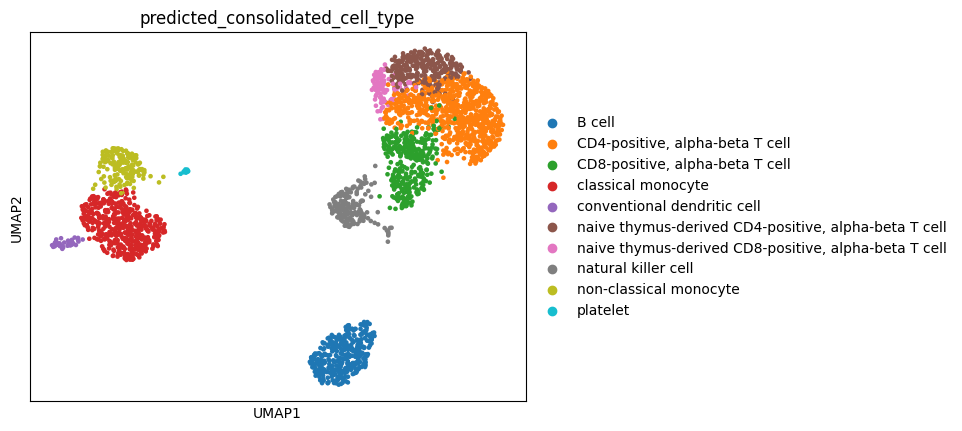

In [16]:
sc.pl.umap(adata, color="predicted_consolidated_cell_type")